# CNN + MaxPool
Restructure code.
Alter model desgin.

In [24]:
from datetime import datetime
print(datetime.now())

2023-03-16 18:27:12.330852


In [25]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

Found GPU at: /device:GPU:0
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [26]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
CFILTERS=128 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=20 
EMBED_DIMEN = 4 # arbitrary hyperparameter
MINLEN=200
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
NUM_LINES = 15   # 15 to analyze all of them
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC

Python 3.9.16
sklearn 1.2.2


In [27]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.canon_lncRNA_transcripts.csv'

In [28]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [29]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = np.power(values,2)
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = 0.0
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN \
                    and gene_id in self.gene2rci.keys():
                        allids.append( (gene_id,tran_id) )
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

## Model

In [30]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    cnn2_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool1_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    cnn3_layer = Conv1D(CFILTERS//2, FILTERSIZE)
    cnn4_layer = Conv1D(CFILTERS//2, FILTERSIZE)
    pool2_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    flat_layer = Flatten()
    #dens_layer = Dense(DCELLS,activation='relu')
    #drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    cnn.add(cnn2_layer)
    cnn.add(pool1_layer)
    cnn.add(cnn3_layer)
    cnn.add(cnn4_layer)
    cnn.add(pool2_layer)
    cnn.add(flat_layer)
    #cnn.add(dens_layer)
    #cnn.add(drop_layer)
    cnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    cnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return cnn

In [31]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-03-16 18:27:14.131793
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 4997, 4)           1028      
                                                                 
 conv1d_52 (Conv1D)          (None, 4990, 128)         4224      
                                                                 
 conv1d_53 (Conv1D)          (None, 4983, 128)         131200    
                                                                 
 max_pooling1d_26 (MaxPoolin  (None, 1244, 128)        0         
 g1D)                                                            
                                                                 
 conv1d_54 (Conv1D)          (None, 1237, 64)          65600     
                                                                 
 conv1d_55 (Conv1D)          (None, 1230, 64)          32832     
                          

## Training

In [32]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # validation_data=(X_valid,y_valid) ) 
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.2f%%' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [33]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            if gene_id in self.val_genes:
                self.val_ids.append(allids[t])
                self.val_seq.append(allseq[t])
                self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                self.train_ids.append(allids[t])
                self.train_seq.append(allseq[t])
                self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-03-16 18:27:14.355170
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4236 sequences.
2023-03-16 18:27:20.206169

Training # 1 1
2023-03-16 18:27:20.207203
2023-03-16 18:27:20.207270
Discriminator ZERO -1
FIT
2023-03-16 18:27:21.420469


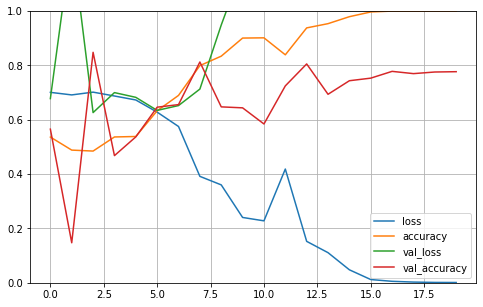


2023-03-16 18:29:44.855656

Testing # 1 1
2023-03-16 18:29:44.855763
2023-03-16 18:29:44.855798
PREDICT
2023-03-16 18:29:45.059309
Test 1:0 718:124 85.27%
Predict 1:0 756:86 89.79%
Test sizes (842, 4997) (842,)
Range of scores: 1.2390294e-31 to 1.0
Score threshold 0.5


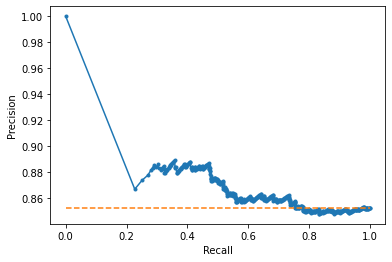

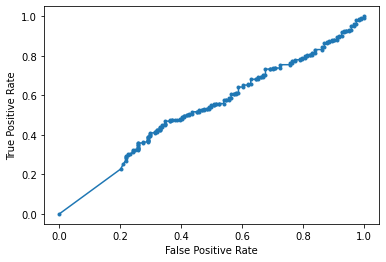

Accuracy: 77.67% Precision: 85.05% Recall: 89.55%
F1: 87.25% MCC: -0.02%
AUPRC: 88.05% AUROC: 53.16%
 accuracy [77.67220902612827]
 precision [85.05291005291006]
 recall [89.55431754874652]
 F1 [87.24559023066485]
 MCC [-0.018427432351891107]
 AUPRC [88.04745273488699]
 AUROC [53.162346122742385]
2023-03-16 18:29:46.070987

Training # 1 2
2023-03-16 18:29:46.071114
2023-03-16 18:29:46.071155
Discriminator ZERO -1
FIT
2023-03-16 18:29:47.221512


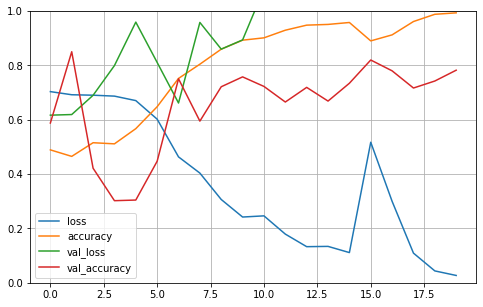


2023-03-16 18:32:10.780989

Testing # 1 2
2023-03-16 18:32:10.781089
2023-03-16 18:32:10.781125
PREDICT
2023-03-16 18:32:10.988196
Test 1:0 750:104 87.82%
Predict 1:0 748:106 87.59%
Test sizes (854, 4997) (854,)
Range of scores: 9.571005e-10 to 1.0
Score threshold 0.5


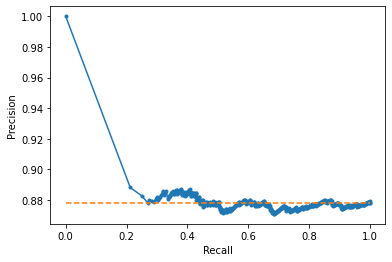

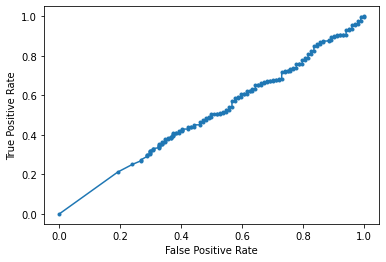

Accuracy: 78.22% Precision: 87.70% Recall: 87.47%
F1: 87.58% MCC: -0.01%
AUPRC: 89.23% AUROC: 49.88%
 accuracy [78.22014051522248]
 precision [87.70053475935828]
 recall [87.46666666666667]
 F1 [87.5834445927904]
 MCC [-0.009867580733564406]
 AUPRC [89.23298660090808]
 AUROC [49.87692307692308]
2023-03-16 18:32:12.275737

Training # 1 3
2023-03-16 18:32:12.277460
2023-03-16 18:32:12.277812
Discriminator ZERO -1
FIT
2023-03-16 18:32:14.394801


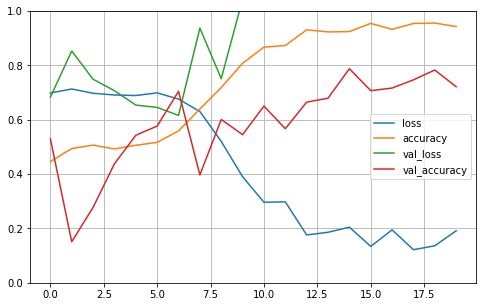


2023-03-16 18:34:38.103755

Testing # 1 3
2023-03-16 18:34:38.105469
2023-03-16 18:34:38.105915
PREDICT
2023-03-16 18:34:38.491413
Test 1:0 704:125 84.92%
Predict 1:0 677:152 81.66%
Test sizes (829, 4997) (829,)
Range of scores: 7.7923064e-11 to 1.0
Score threshold 0.5


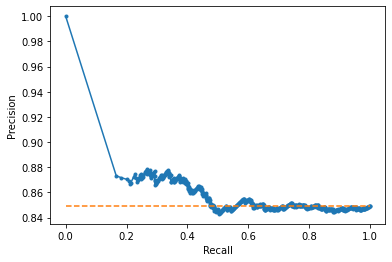

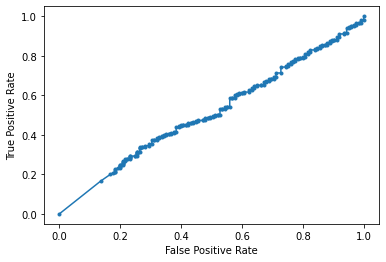

Accuracy: 72.14% Precision: 84.93% Recall: 81.68%
F1: 83.27% MCC: 0.00%
AUPRC: 86.93% AUROC: 51.31%
 accuracy [72.1351025331725]
 precision [84.93353028064993]
 recall [81.67613636363636]
 F1 [83.2729905865315]
 MCC [0.0007040724295474008]
 AUPRC [86.92813218608948]
 AUROC [51.30681818181818]
2023-03-16 18:34:39.781129

Training # 1 4
2023-03-16 18:34:39.781273
2023-03-16 18:34:39.781315
Discriminator ZERO -1
FIT
2023-03-16 18:34:40.948024


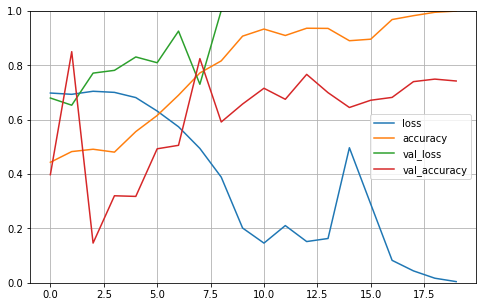


2023-03-16 18:36:41.854274

Testing # 1 4
2023-03-16 18:36:41.856881
2023-03-16 18:36:41.860282
PREDICT
2023-03-16 18:36:42.087523
Test 1:0 736:126 85.38%
Predict 1:0 748:114 86.77%
Test sizes (862, 4997) (862,)
Range of scores: 1.4539278e-09 to 1.0
Score threshold 0.5


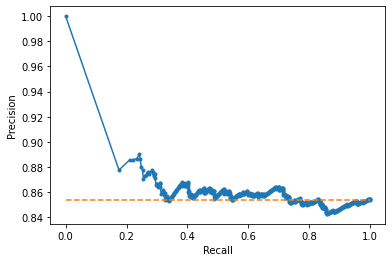

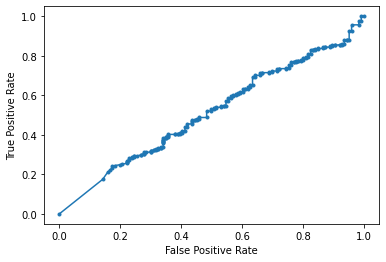

Accuracy: 74.25% Precision: 84.36% Recall: 85.73%
F1: 85.04% MCC: -0.07%
AUPRC: 87.36% AUROC: 51.23%
 accuracy [74.24593967517401]
 precision [84.35828877005348]
 recall [85.7336956521739]
 F1 [85.04043126684635]
 MCC [-0.07428671688130646]
 AUPRC [87.35747815106303]
 AUROC [51.231991890959286]
2023-03-16 18:36:43.261196

Training # 1 5
2023-03-16 18:36:43.261340
2023-03-16 18:36:43.261381
Discriminator ZERO -1
FIT
2023-03-16 18:36:44.411896


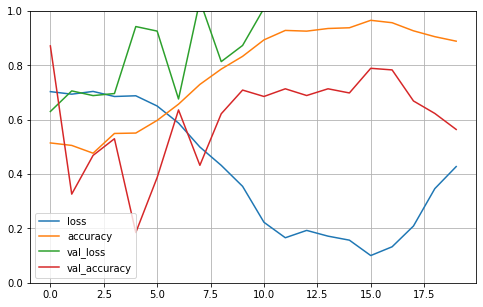


2023-03-16 18:38:45.789544

Testing # 1 5
2023-03-16 18:38:45.789635
2023-03-16 18:38:45.789672
PREDICT
2023-03-16 18:38:46.003111
Test 1:0 740:109 87.16%
Predict 1:0 494:355 58.19%
Test sizes (849, 4997) (849,)
Range of scores: 1.7047982e-16 to 1.0
Score threshold 0.5


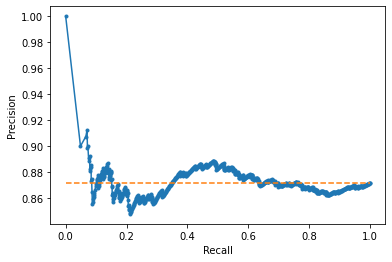

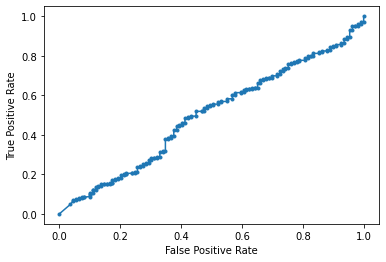

Accuracy: 56.42% Precision: 87.45% Recall: 58.38%
F1: 70.02% MCC: 0.01%
AUPRC: 87.60% AUROC: 49.88%
 accuracy [56.419316843345115]
 precision [87.4493927125506]
 recall [58.37837837837838]
 F1 [70.01620745542951]
 MCC [0.010156876562466863]
 AUPRC [87.60184973862677]
 AUROC [49.880981899330514]
2023-03-16 18:38:46.937061

Training # 2 1
2023-03-16 18:38:46.938555
2023-03-16 18:38:46.938613
Discriminator ZERO -1
FIT
2023-03-16 18:38:48.645779


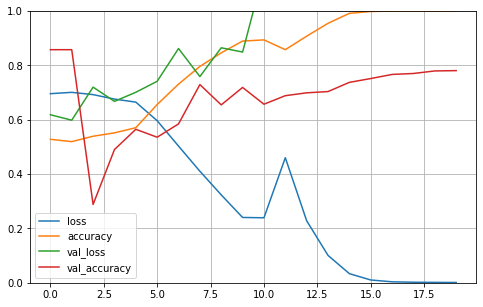


2023-03-16 18:41:13.199246

Testing # 2 1
2023-03-16 18:41:13.200747
2023-03-16 18:41:13.201103
PREDICT
2023-03-16 18:41:13.657474
Test 1:0 735:122 85.76%
Predict 1:0 767:90 89.50%
Test sizes (857, 4997) (857,)
Range of scores: 2.2390469e-07 to 1.0
Score threshold 0.5


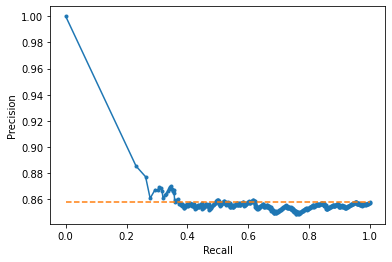

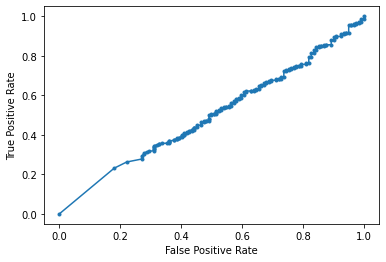

Accuracy: 78.06% Precision: 85.66% Recall: 89.39%
F1: 87.48% MCC: -0.01%
AUPRC: 87.72% AUROC: 49.96%
 accuracy [78.0630105017503]
 precision [85.65840938722295]
 recall [89.38775510204081]
 F1 [87.48335552596538]
 MCC [-0.00884640296259986]
 AUPRC [87.721638702532]
 AUROC [49.9615255938441]
2023-03-16 18:41:14.834891

Training # 2 2
2023-03-16 18:41:14.836476
2023-03-16 18:41:14.836806
Discriminator ZERO -1
FIT
2023-03-16 18:41:16.005944


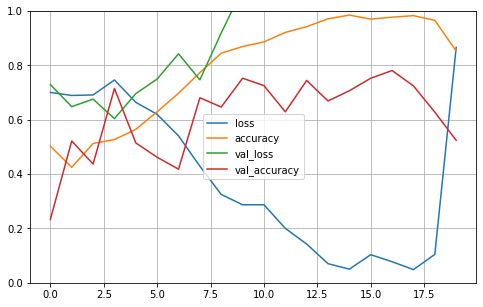


2023-03-16 18:43:39.389720

Testing # 2 2
2023-03-16 18:43:39.389825
2023-03-16 18:43:39.389869
PREDICT
2023-03-16 18:43:39.604402
Test 1:0 725:124 85.39%
Predict 1:0 481:368 56.65%
Test sizes (849, 4997) (849,)
Range of scores: 8.6902065e-12 to 1.0
Score threshold 0.5


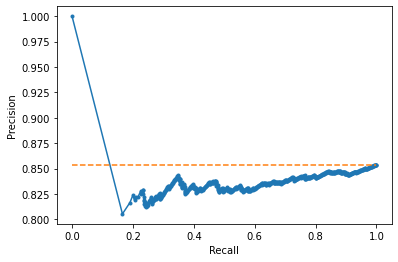

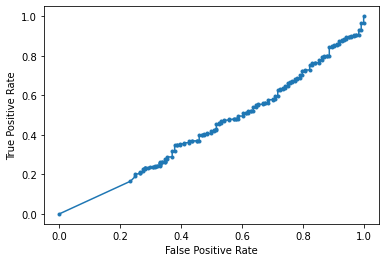

Accuracy: 52.41% Precision: 83.37% Recall: 55.31%
F1: 66.50% MCC: -0.07%
AUPRC: 84.60% AUROC: 43.22%
 accuracy [52.41460541813898]
 precision [83.36798336798337]
 recall [55.31034482758621]
 F1 [66.50082918739635]
 MCC [-0.06560609501712146]
 AUPRC [84.60252393462162]
 AUROC [43.22246941045606]
2023-03-16 18:43:40.752141

Training # 2 3
2023-03-16 18:43:40.752332
2023-03-16 18:43:40.754139
Discriminator ZERO -1
FIT
2023-03-16 18:43:41.938081


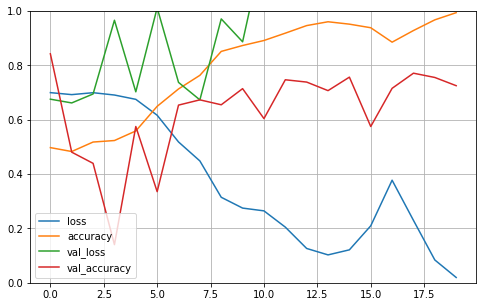


2023-03-16 18:45:43.974168

Testing # 2 3
2023-03-16 18:45:43.974289
2023-03-16 18:45:43.974326
PREDICT
2023-03-16 18:45:44.173951
Test 1:0 711:115 86.08%
Predict 1:0 670:156 81.11%
Test sizes (826, 4997) (826,)
Range of scores: 1.3626359e-16 to 1.0
Score threshold 0.5


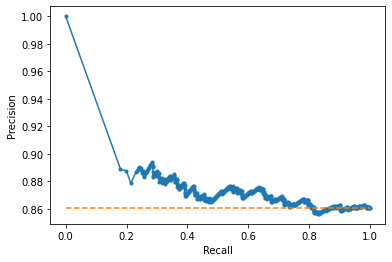

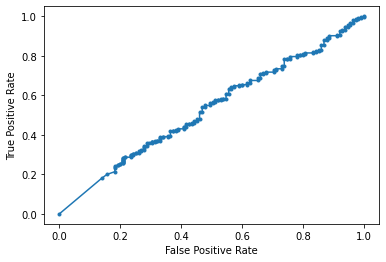

Accuracy: 72.52% Precision: 86.12% Recall: 81.15%
F1: 83.56% MCC: 0.00%
AUPRC: 88.42% AUROC: 53.07%
 accuracy [72.5181598062954]
 precision [86.11940298507463]
 recall [81.15330520393812]
 F1 [83.56263577118031]
 MCC [0.0025096003359190064]
 AUPRC [88.41749017829032]
 AUROC [53.07160765608757]
2023-03-16 18:45:45.076812

Training # 2 4
2023-03-16 18:45:45.077496
2023-03-16 18:45:45.077540
Discriminator ZERO -1
FIT
2023-03-16 18:45:46.226247


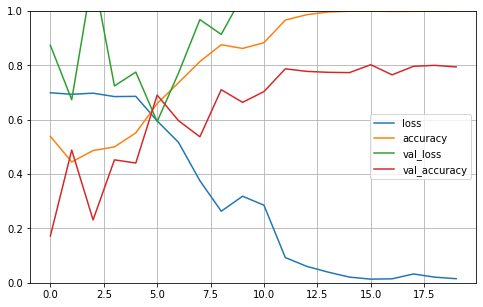


2023-03-16 18:48:09.965592

Testing # 2 4
2023-03-16 18:48:09.967070
2023-03-16 18:48:09.967421
PREDICT
2023-03-16 18:48:10.192508
Test 1:0 753:107 87.56%
Predict 1:0 772:88 89.77%
Test sizes (860, 4997) (860,)
Range of scores: 7.7960416e-05 to 1.0
Score threshold 0.5


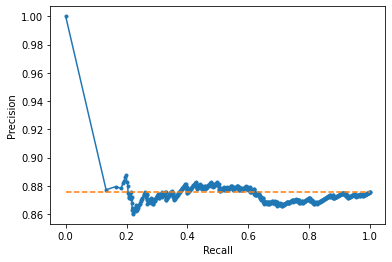

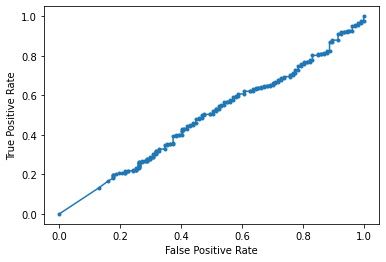

Accuracy: 79.42% Precision: 87.31% Recall: 89.51%
F1: 88.39% MCC: -0.02%
AUPRC: 88.24% AUROC: 48.90%
 accuracy [79.4186046511628]
 precision [87.30569948186529]
 recall [89.50863213811421]
 F1 [88.39344262295081]
 MCC [-0.022653465595345482]
 AUPRC [88.24039530167967]
 AUROC [48.89538419530601]
2023-03-16 18:48:11.557567

Training # 2 5
2023-03-16 18:48:11.559121
2023-03-16 18:48:11.559495
Discriminator ZERO -1
FIT
2023-03-16 18:48:13.724012


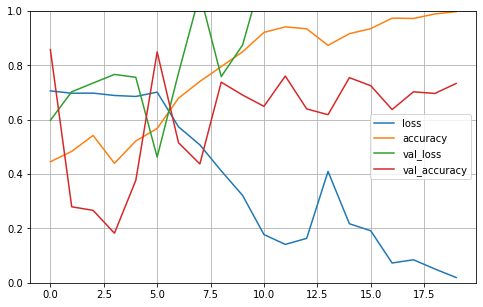


2023-03-16 18:50:37.176995

Testing # 2 5
2023-03-16 18:50:37.178816
2023-03-16 18:50:37.179259
PREDICT
2023-03-16 18:50:37.628835
Test 1:0 724:120 85.78%
Predict 1:0 699:145 82.82%
Test sizes (844, 4997) (844,)
Range of scores: 6.996562e-08 to 1.0
Score threshold 0.5


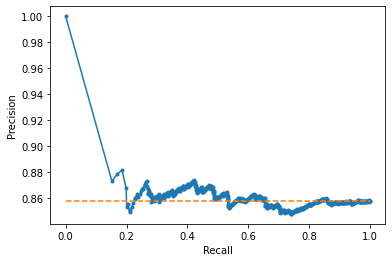

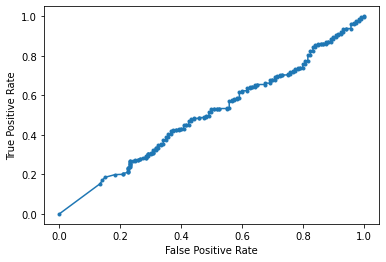

Accuracy: 73.34% Precision: 85.69% Recall: 82.73%
F1: 84.19% MCC: -0.01%
AUPRC: 87.18% AUROC: 50.37%
 accuracy [73.34123222748815]
 precision [85.69384835479255]
 recall [82.73480662983425]
 F1 [84.1883345045678]
 MCC [-0.00554141720181402]
 AUPRC [87.18486073988736]
 AUROC [50.36774861878454]
2023-03-16 18:50:38.706758


In [34]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_sequence(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_sequence(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [35]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 71.44% std 9.39
 precision mean 85.76% std 1.42
 recall mean 80.09% std 12.68
 F1 mean 82.33% std 7.68
 MCC mean -0.02% std 0.03
 AUPRC mean 87.53% std 1.23
 AUROC mean 50.10% std 2.79
 accuracy [[77.67220902612827], [78.22014051522248], [72.1351025331725], [74.24593967517401], [56.419316843345115], [78.0630105017503], [52.41460541813898], [72.5181598062954], [79.4186046511628], [73.34123222748815]]
 precision [[85.05291005291006], [87.70053475935828], [84.93353028064993], [84.35828877005348], [87.4493927125506], [85.65840938722295], [83.36798336798337], [86.11940298507463], [87.30569948186529], [85.69384835479255]]
 recall [[89.55431754874652], [87.46666666666667], [81.67613636363636], [85.7336956521739], [58.37837837837838], [89.38775510204081], [55.31034482758621], [81.15330520393812], [89.50863213811421], [82.73480662983425]]
 F1 [[87.24559023066485], [87.5834445927904], [83.2729905865315], [85.04043126684635], [70.01620745542951], [87.48335552596538], [66.5008291873